# Dokumentasi Model Deteksi & Klasifikasi Esai Siswa dan ChatGPT

Notebook ini bertujuan untuk membangun sistem klasifikasi esai siswa dan ChatPGT menggunakan dua dataset: Student_ChatGPT dan Only_ChatGPT. Sistem ini mencakup arsitektur Bi-Encoder dan classifier untuk membedakan teks dari Student dan ChatGPT. Dokumentasi ini memandu Anda melalui proses pembentukan sistem secara bertahap.

## 1. Import Library

Pada langkah ini, semua library yang diperlukan untuk pemrosesan teks, pembelajaran mesin, dan visualisasi data diimpor:

In [58]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize
import nltk
import pickle
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# Set seed untuk reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## 2. Load Dataset

Dua dataset utama diimpor:
1. Dataset Student_ChatGPT: Berisi interaksi antara Student dan ChatGPT dengan format:
- Kolom 1: Teks dari Student.
- Kolom 2: Respon dari ChatGPT.
2. Dataset Only_ChatGPT: Berisi teks yang dihasilkan oleh ChatGPT terkait pengetahuan satu mata pelajaran selama satu tahun (2 semester).

Dataset ini digunakan untuk membangun model Bi-Encoder dan classifier.

In [60]:
# Load both datasets
student_chatgpt = pd.read_excel("example_datasets/examples-datasets-mar25.xlsx")
only_chatgpt = pd.read_excel("example_datasets/knowledge-datasets-mar25.xlsx")

In [61]:
# Tampilkan informasi dataset
print("Dataset Student_ChatGPT:")
print(student_chatgpt.info())
print("\nDataset Only_ChatGPT:")
print(only_chatgpt.info())

# Tampilkan beberapa baris awal dataset
print("\nContoh Data Student_ChatGPT:")
display(student_chatgpt.head())

print("\nContoh Data Only_ChatGPT:")
display(only_chatgpt.head())

Dataset Student_ChatGPT:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pelajar  68 non-null     object
 1   GPT      68 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB
None

Dataset Only_ChatGPT:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   GPT     118 non-null    object
dtypes: object(1)
memory usage: 1.1+ KB
None

Contoh Data Student_ChatGPT:


,Pelajar,GPT
0,Teknologi adalah segala sesuatu yang menciptak...,"Teknologi, dalam konteks esai ini, dapat didef..."
1,"Sekarang, mari kita lihat fakta umum yang seri...",Tantangan terbesar yang dihadapi oleh generasi...
2,"Jika ditelisik lebih jauh, sudah banyak kiprah...",Masyarakat memiliki pandangan yang beragam ter...
3,Lalu sebenarnya apa saja peran pelajar yang da...,Salah satu contoh pelajar yang berhasil memanf...
4,Salah satu pelajar yang berkiprah dalam menyok...,Dukungan orang tua sangat penting dalam perkem...



Contoh Data Only_ChatGPT:


,GPT
0,Teknologi adalah sekumpulan pengetahuan dan ke...
1,"Di era digital ini, pelajar menghadapi berbaga..."
2,Masyarakat memiliki pandangan yang beragam ter...
3,Salah satu contoh nyata dari pelajar yang berh...
4,"Namun, untuk dapat berhasil dalam memanfaatkan..."


## 3. Preprocessing Data

Langkah ini memproses data mentah menjadi format yang siap digunakan oleh model:
1. Preprocessing Teks:
- Semua teks diubah menjadi huruf kecil.
- Teks dipisahkan menjadi kalimat menggunakan tokenisasi kalimat.
2. Distribusi Data:
- Total jumlah kalimat dari masing-masing sumber (Student, ChatGPT dari Student_ChatGPT, dan Only_ChatGPT) dihitung dan ditampilkan.

In [62]:
# Fungsi untuk preprocessing teks
def preprocess_text(text):
    """
    Preprocessing teks:
    - Mengubah teks menjadi huruf kecil.
    - Membagi teks menjadi kalimat (tokenisasi kalimat).
    
    Args:
        text (str): Teks input.
        
    Returns:
        list: Daftar kalimat yang telah diproses.
    """
    if not isinstance(text, str) or text.strip() == "":
        return []
    text = text.lower().strip()
    sentences = sent_tokenize(text)
    return sentences

# Preprocessing data Student_ChatGPT
student_sentences = []
chatgpt_sentences_1 = []  # ChatGPT dari dataset Student_ChatGPT

# Proses teks Student
for text in student_chatgpt['Pelajar']:
    student_sentences.extend(preprocess_text(text))

# Proses teks ChatGPT (dari Student_ChatGPT)
for text in student_chatgpt['GPT']:
    chatgpt_sentences_1.extend(preprocess_text(text))

# Preprocessing data Only_ChatGPT
chatgpt_sentences_2 = []  # ChatGPT dari dataset Only_ChatGPT

# Proses teks ChatGPT (dari Only_ChatGPT)
for text in only_chatgpt['GPT']:
    chatgpt_sentences_2.extend(preprocess_text(text))

# Tampilkan jumlah data hasil preprocessing
print(f"Total kalimat Student: {len(student_sentences)}")
print(f"Total kalimat ChatGPT (Student_ChatGPT): {len(chatgpt_sentences_1)}")
print(f"Total kalimat ChatGPT (Only_ChatGPT): {len(chatgpt_sentences_2)}")

Total kalimat Student: 306
Total kalimat ChatGPT (Student_ChatGPT): 248
Total kalimat ChatGPT (Only_ChatGPT): 408


## 4. Ekstraksi Fitur Stylometric

Fitur stylometric diekstraksi untuk memberikan representasi tambahan tentang pola teks. Fitur ini meliputi:
- Panjang Kata Rata-Rata: Rata-rata panjang kata dalam kalimat.
- Rasio Kata Unik: Proporsi kata unik terhadap total kata.
- Rasio Tanda Baca: Proporsi tanda baca terhadap total karakter.
- Rasio Huruf Besar: Proporsi huruf besar terhadap total karakter.
- Rasio Kata Benda dan Kata Kerja: Proporsi kata benda dan kata kerja berdasarkan POS tagging.

Fitur ini digunakan sebagai input tambahan untuk model classifier.

In [63]:
# Fungsi untuk ekstraksi fitur stylometric
def extract_stylometric_features(text):
    """
    Ekstraksi fitur stylometric dari teks:
    - Panjang kata rata-rata
    - Rasio kata unik
    - Rasio tanda baca
    
     Args:
        text (str): Input teks.
        
    Returns:
        dict: Fitur stylometric.
    """
    # Basic features
    n_chars = len(text)
    n_words = len(text.split())
    avg_word_length = n_chars / n_words if n_words > 0 else 0
    unique_word_ratio = len(set(text.split())) / n_words if n_words > 0 else 0
    
    # Syntactic features
    punctuation_ratio = len(re.findall(r'[.,!?;:]', text)) / n_chars if n_chars > 0 else 0
    
    return {
        'avg_word_length': avg_word_length,
        'unique_word_ratio': unique_word_ratio,
        'punctuation_ratio': punctuation_ratio,
        'sentence_length': n_words
    }

# Ekstraksi fitur untuk semua dataset
print("Ekstraksi fitur stylometric untuk Student...")
student_features = [extract_stylometric_features(text) for text in student_sentences]

print("Ekstraksi fitur stylometric untuk ChatGPT (Student_ChatGPT)...")
chatgpt_features_1 = [extract_stylometric_features(text) for text in chatgpt_sentences_1]

print("Ekstraksi fitur stylometric untuk ChatGPT (Only_ChatGPT)...")
chatgpt_features_2 = [extract_stylometric_features(text) for text in chatgpt_sentences_2]

# Konversi fitur ke DataFrame
student_features_df = pd.DataFrame(student_features)
chatgpt_features_1_df = pd.DataFrame(chatgpt_features_1)
chatgpt_features_2_df = pd.DataFrame(chatgpt_features_2)

# Tampilkan beberapa fitur hasil ekstraksi
print("\nFitur Stylometric Student:")
display(student_features_df.head())

print("\nFitur Stylometric ChatGPT (Student_ChatGPT):")
display(chatgpt_features_1_df.head())

print("\nFitur Stylometric ChatGPT (Only_ChatGPT):")
display(chatgpt_features_2_df.head())

Ekstraksi fitur stylometric untuk Student...
Ekstraksi fitur stylometric untuk ChatGPT (Student_ChatGPT)...
Ekstraksi fitur stylometric untuk ChatGPT (Only_ChatGPT)...

Fitur Stylometric Student:


,avg_word_length,unique_word_ratio,punctuation_ratio,sentence_length
0,8.090909,1.000000,0.011236,11
1,7.291667,0.916667,0.011429,24
2,8.307692,1.000000,0.027778,13
3,7.933333,1.000000,0.016807,15
4,6.666667,1.000000,0.016667,9



Fitur Stylometric ChatGPT (Student_ChatGPT):


,avg_word_length,unique_word_ratio,punctuation_ratio,sentence_length
0,7.920000,0.960000,0.030303,25
1,7.777778,1.000000,0.014286,9
2,7.619048,0.952381,0.031250,21
3,7.176471,1.000000,0.024590,17
4,7.500000,1.000000,0.020000,20



Fitur Stylometric ChatGPT (Only_ChatGPT):


,avg_word_length,unique_word_ratio,punctuation_ratio,sentence_length
0,8.250000,1.000000,0.022727,16
1,7.000000,0.909091,0.012987,22
2,9.000000,1.000000,0.037037,9
3,6.956522,0.913043,0.031250,23
4,7.454545,0.954545,0.018293,22


## 5. Normalisasi Fitur Stylometric

Semua fitur stylometric dinormalisasi menggunakan StandardScaler untuk memastikan skala yang konsisten. Langkah ini penting untuk meningkatkan performa model saat memproses input dari berbagai skala.

In [64]:
# Gabungkan semua fitur untuk normalisasi
all_features = pd.concat([student_features_df, chatgpt_features_1_df, chatgpt_features_2_df], axis=0)

# Normalisasi fitur menggunakan StandardScaler
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_features)

# Pisahkan kembali fitur yang telah dinormalisasi
n_student = len(student_features_df)
n_chatgpt_1 = len(chatgpt_features_1_df)

student_features_normalized = normalized_features[:n_student]
chatgpt_features_1_normalized = normalized_features[n_student:n_student + n_chatgpt_1]
chatgpt_features_2_normalized = normalized_features[n_student + n_chatgpt_1:]

print("Fitur Student setelah normalisasi:")
print(student_features_normalized[:5])

# Simpan scaler untuk inference nanti
with open('scaler_stylometric.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Fitur Student setelah normalisasi:
[[ 0.80437515  0.76389728 -0.39398472 -1.10349806]
 [-0.37509889 -0.95249186 -0.38143902  0.91971653]
 [ 1.12429083  0.76389728  0.68343507 -0.79223428]
 [ 0.5718343   0.76389728 -0.03114349 -0.48097049]
 [-1.29743641  0.76389728 -0.04026577 -1.41476184]]


## 6. Visualisasi Fitur Stylometric

Distribusi fitur stylometric divisualisasikan untuk mengidentifikasi pola perbedaan antara teks dari Student dan ChatGPT. Visualisasi ini membantu memahami karakteristik unik masing-masing sumber teks.

In [65]:
# Tambahkan label pada dataset untuk visualisasi
student_features_df['label'] = 'Esai Siswa'
chatgpt_features_1_df['label'] = 'Esai ChatGPT'
chatgpt_features_2_df['label'] = 'Pengetahuan ChatGPT'

# Gabungkan dataset
combined_features = pd.concat([student_features_df, chatgpt_features_1_df, chatgpt_features_2_df], axis=0)

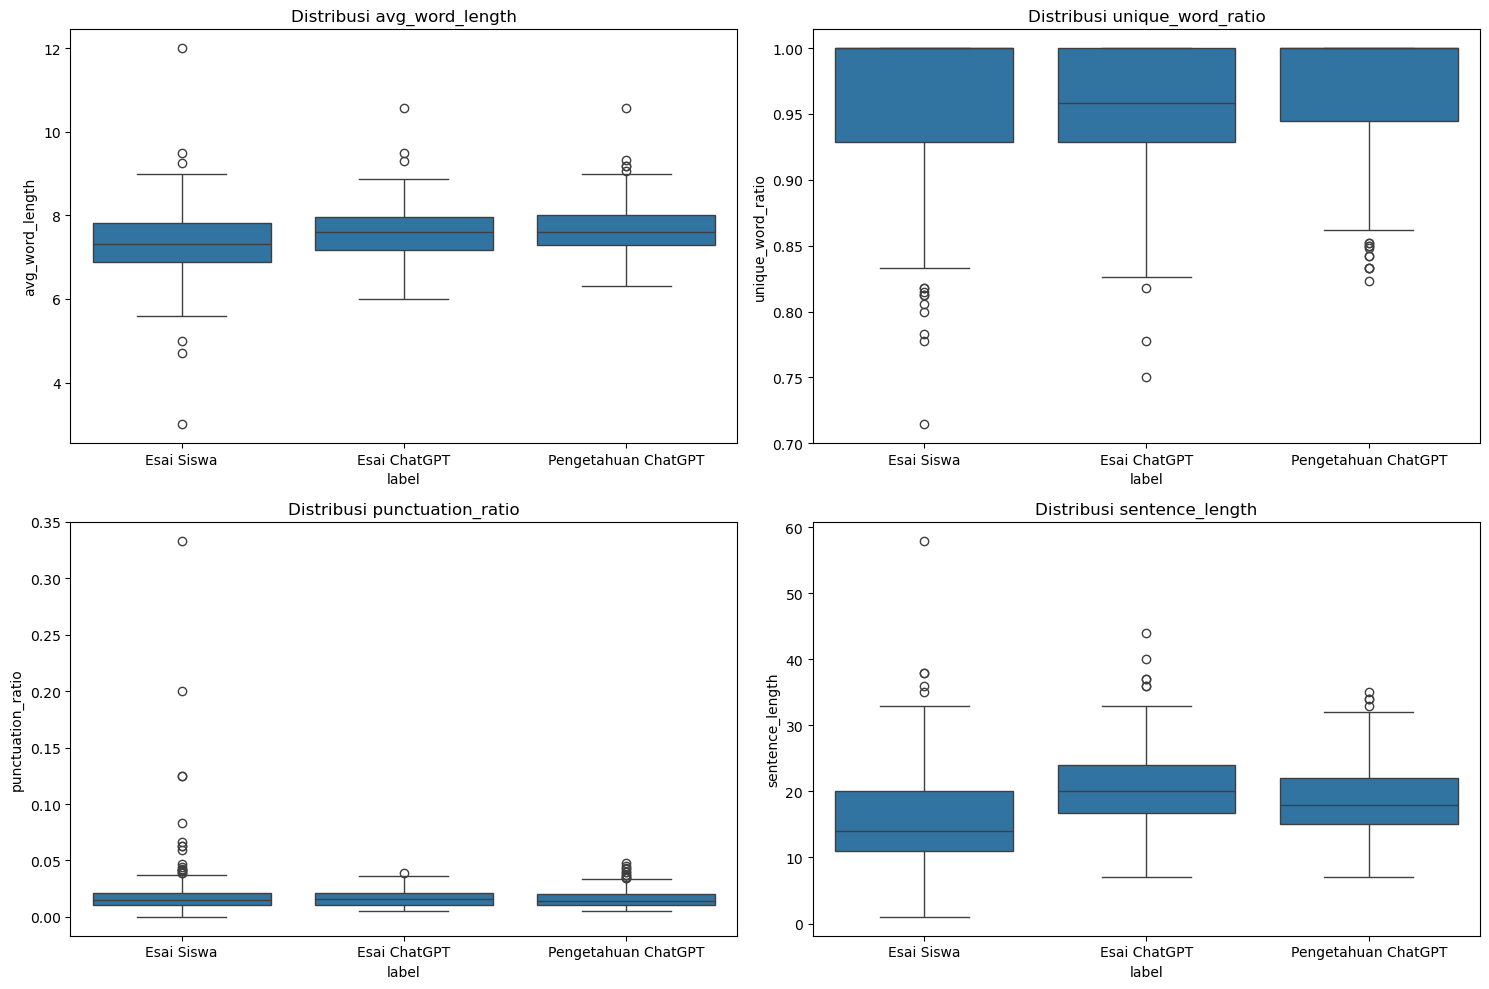

In [66]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['avg_word_length', 'unique_word_ratio', 'punctuation_ratio', 'sentence_length']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='label', y=feature, data=combined_features)
    plt.title(f'Distribusi {feature}')
plt.tight_layout()
plt.show()

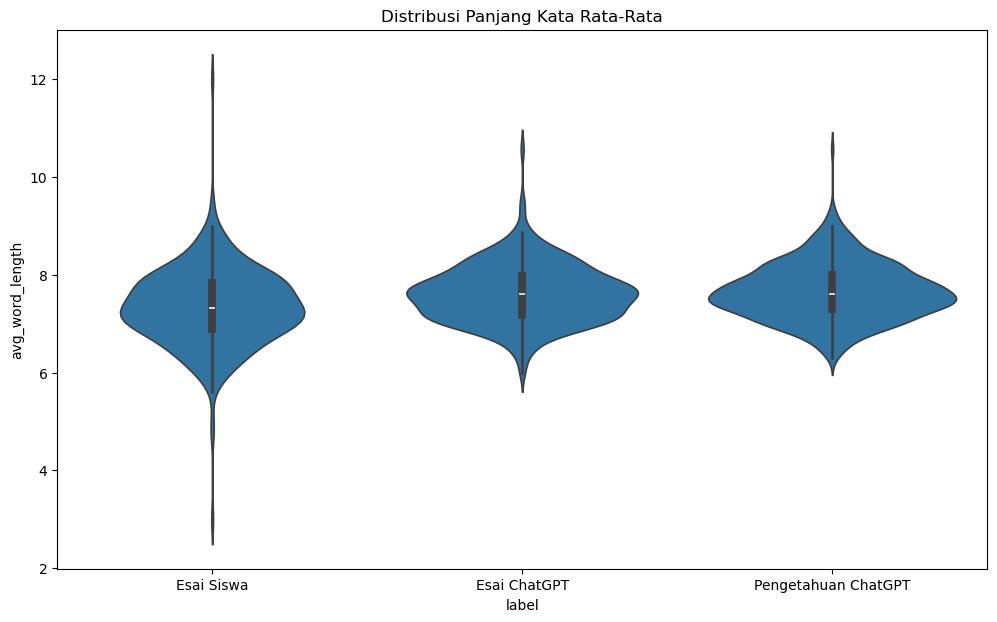

In [67]:
plt.figure(figsize=(12, 7))
sns.violinplot(x='label', y='avg_word_length', data=combined_features, inner='box')
plt.title('Distribusi Panjang Kata Rata-Rata')
plt.show()

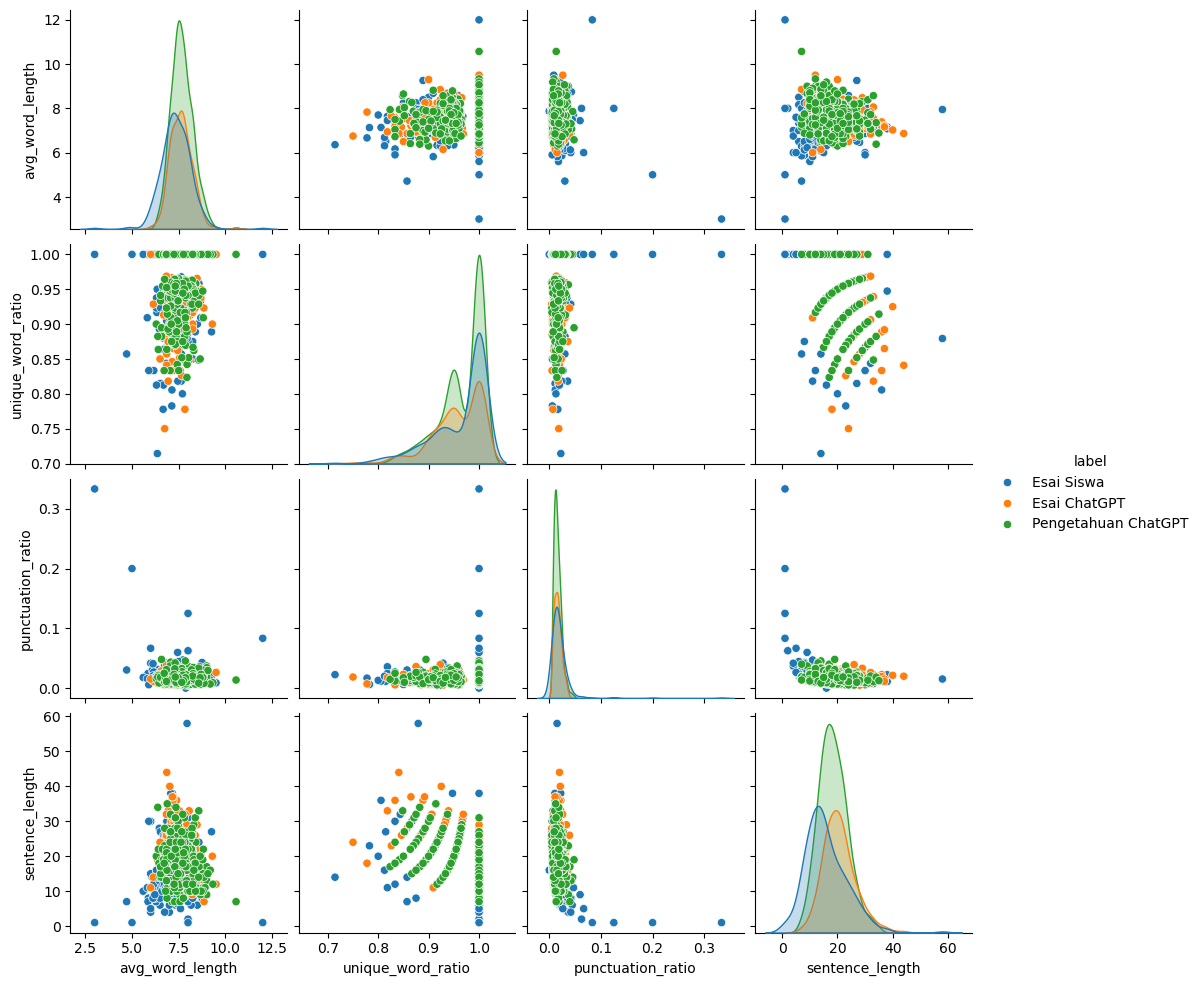

In [68]:
sns.pairplot(combined_features, hue='label', vars=['avg_word_length', 'unique_word_ratio', 'punctuation_ratio', 'sentence_length'])
plt.show()

## 7. Inisialisasi BERT Tokenizer

Teks dari dataset di-tokenisasi menggunakan tokenizer pretrained dari IndoBERT:
- `input_ids`: Token ID untuk setiap kata dalam teks.
- `attention_mask`: Masking untuk menandai kata yang relevan dan padding.

Tokenisasi diperlukan agar teks dapat diproses oleh model BERT.

In [ ]:
# Inisialisasi tokenizer IndoBERT
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Fungsi untuk tokenisasi teks
def tokenize_text(texts, max_length=128):
    """
    Tokenisasi teks menggunakan tokenizer IndoBERT.
    
    Args:
        texts (list): Daftar teks yang akan di-tokenisasi.
        max_length (int): Panjang maksimum token.
        
    Returns:
        dict: Token hasil tokenisasi, termasuk input_ids dan attention_mask.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [ ]:
# Tokenisasi data
print("Tokenisasi kalimat Student...")
student_tokens = tokenize_text(student_sentences)

print("Tokenisasi kalimat ChatGPT (Student_ChatGPT)...")
chatgpt_tokens_1 = tokenize_text(chatgpt_sentences_1)

print("Tokenisasi kalimat ChatGPT (Only_ChatGPT)...")
chatgpt_tokens_2 = tokenize_text(chatgpt_sentences_2)

# Tampilkan hasil tokenisasi (contoh: Student)
print("\nContoh hasil tokenisasi:")
print(student_tokens['input_ids'][:1])  # Input token ID
print(student_tokens['attention_mask'][:1])  # Attention mask

In [ ]:
# Memeriksa distribusi panjang token untuk memastikan max_length cukup
student_lengths = [sum(mask) for mask in student_tokens['attention_mask'].numpy()]
plt.figure(figsize=(10, 6))
plt.hist(student_lengths, bins=30)
plt.title('Distribusi Panjang Token (Student)')
plt.xlabel('Jumlah Token Aktif')
plt.ylabel('Frekuensi')
plt.show()
print(f"Rata-rata panjang token: {np.mean(student_lengths):.2f}")
print(f"Persentase terpotong: {sum(l == 128 for l in student_lengths) / len(student_lengths) * 100:.2f}%")

In [ ]:
# Mendekode token untuk memastikan tokenisasi berfungsi dengan baik
sample_text = student_sentences[0]
sample_tokens = tokenizer.encode(sample_text)
print(f"Teks asli: {sample_text}")
print(f"Token ID: {sample_tokens}")
print(f"Token dekode: {tokenizer.decode(sample_tokens)}")

In [ ]:
# Jika tokenisasi memakan waktu lama, pertimbangkan untuk menyimpannya
tokenized_data = {
    'student': student_tokens,
    'chatgpt_1': chatgpt_tokens_1,
    'chatgpt_2': chatgpt_tokens_2
}

# Menyimpan input_ids dan attention_mask sebagai numpy arrays
tokenized_numpy = {
    'student': {
        'input_ids': student_tokens['input_ids'].numpy(),
        'attention_mask': student_tokens['attention_mask'].numpy()
    },
    'chatgpt_1': {
        'input_ids': chatgpt_tokens_1['input_ids'].numpy(),
        'attention_mask': chatgpt_tokens_1['attention_mask'].numpy()
    },
    'chatgpt_2': {
        'input_ids': chatgpt_tokens_2['input_ids'].numpy(),
        'attention_mask': chatgpt_tokens_2['attention_mask'].numpy()
    }
}

with open('tokenized_data.pkl', 'wb') as f:
    pickle.dump(tokenized_numpy, f)

## 8. Membuat Model BERT Bi-Encoder

Dua model Bi-Encoder dibuat:
- Bi-Encoder untuk Only_ChatGPT: Digunakan untuk memahami teks dari dataset Only_ChatGPT.
- Bi-Encoder untuk Student_ChatGPT: Digunakan untuk memahami interaksi antara Student dan ChatGPT.

Arsitektur Bi-Encoder melibatkan:
- IndoBERT sebagai backbone untuk menghasilkan embeddings.
- Dense Layers untuk fine-tuning.
- L2 Normalization untuk menghasilkan embeddings yang seragam.

In [ ]:
# Load model IndoBERT
bert_model = TFBertModel.from_pretrained("indobenchmark/indobert-base-p2")

# Fungsi untuk membuat Bi-Encoder
def build_bi_encoder(bert_model):
    """
    Membuat model Bi-Encoder dengan IndoBERT.
    
    Args:
        bert_model (TFBertModel): Model dasar IndoBERT.
        
    Returns:
        tf.keras.Model: Model Bi-Encoder.
    """
    # Input layer untuk token ID dan attention mask
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")
    
    # Extract CLS token embeddings dari IndoBERT
    bert_output = bert_model(input_ids, attention_mask=attention_mask)[0][:, 0, :]  # [CLS] token
    
    # Dense layer untuk fine-tuning
    dense1_chatgpt = tf.keras.layers.Dense(256, activation="relu")(bert_output)
    dropout1_chatgpt = tf.keras.layers.Dropout(0.1)(dense1_chatgpt)
    dense2_chatgpt = tf.keras.layers.Dense(128, activation="relu")(dropout1_chatgpt)
    dropout2_chatgpt = tf.keras.layers.Dropout(0.1)(dense2_chatgpt)
    dense3_chatgpt = tf.keras.layers.Dense(128)(dropout2_chatgpt)
    
    # Normalisasi output (L2 normalization)
    normalized_output = tf.nn.l2_normalize(dense3_chatgpt, axis=1)
    
    # Model Bi-Encoder
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=normalized_output)

# Buat dua Bi-Encoder
bi_encoder_only_chatgpt = build_bi_encoder(bert_model)
bi_encoder_student_chatgpt = build_bi_encoder(bert_model)

# Tampilkan arsitektur
print("Bi-Encoder untuk Only_ChatGPT:")
bi_encoder_only_chatgpt.summary()

print("\nBi-Encoder untuk Student_ChatGPT:")
bi_encoder_student_chatgpt.summary()

## 9. Constrastive Loss

Contrastive loss digunakan untuk melatih Bi-Encoder dengan tujuan:
- Pasangan kalimat yang mirip memiliki nilai similarity tinggi (loss rendah).
- Pasangan kalimat yang tidak mirip memiliki nilai similarity rendah (loss tinggi).

Datasets Student_ChatGPT: variable -> student_sentences & chatgpt_sentences_1
Pasangan Positif:
- Student - Student Dalam satu data, antar kalimat
- Student - Student Beda data, Antar kalimat
- ChatGPT - ChatGPT Dalam satu data, antar kalimat
- ChatGPT - ChatGPT Beda data, Antar kalimat

Pasangan Negatif:
- Student - ChatGPT Beda data, Antar kalimat

Datasets Only_ChatGPT: variable -> chatgpt_sentences_2
Pasangan Positif:
- ChatGPT - ChatGPT Dalam satu data, antar kalimat
- ChatGPT - ChatGPT Beda data, Antar kalimat

In [ ]:
# Fungsi untuk contrastive loss
def contrastive_loss(margin=1.0):
    """
    Implementasi contrastive loss.
    
    Args:
        margin (float): Margin untuk pasangan yang tidak mirip.
        
    Returns:
        function: Fungsi loss.
    """
    def loss_fn(y_true, y_pred):
        """
        Args:
            y_true: 1 untuk pasangan mirip, 0 untuk tidak mirip.
            y_pred: Cosine similarity antara dua embeddings.
        """
        distance = 1 - y_pred  # Konversi similarity ke distance
        positive_loss = y_true * tf.square(distance)
        negative_loss = (1 - y_true) * tf.square(tf.maximum(margin - distance, 0))
        return tf.reduce_mean(positive_loss + negative_loss)
    return loss_fn

## 10. Train Bi-Encoder

Kedua Bi-Encoder dilatih secara terpisah:
1. Only_ChatGPT:
- Pasangan positif: Kalimat yang saling berdekatan dalam satu bab.
2. Student_ChatGPT:
- Pasangan positif: Student dan ChatGPT untuk soal yang sama.
- Pasangan negatif: Student dengan Student atau ChatGPT dengan ChatGPT.

Hasil pelatihan divisualisasikan untuk memantau performa loss selama training dan validation.

### 10.2. Training Student - ChatGPT

In [ ]:
# Compile Bi-Encoder untuk Student_ChatGPT
bi_encoder_student_chatgpt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=contrastive_loss(margin=1.0)
)

# Training untuk Student_ChatGPT
print("Training Bi-Encoder untuk Student_ChatGPT...")
history_student_chatgpt = bi_encoder_student_chatgpt.fit(
    x={
        "input_ids": tokenize_text(student_sentences)['input_ids'],
        "attention_mask": tokenize_text(student_sentences)['attention_mask']
    },
    y=student_student_sentenceslabels,
    epochs=3,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

### 10.3. Training Only ChatGPT

In [ ]:
# Compile model untuk Only_ChatGPT
bi_encoder_only_chatgpt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=contrastive_loss(),
    metrics=['accuracy']
)

# Training untuk Only_ChatGPT
print("Training Bi-Encoder untuk Only_ChatGPT...")
history_only_chatgpt = bi_encoder_only_chatgpt.fit(
    x=train_data_oc,
    y=train_labels_oc,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

### 10.4. Training History

In [ ]:
# Plot training history untuk Student_ChatGPT
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_student_chatgpt.history['loss'], label='Training Loss')
plt.plot(history_student_chatgpt.history['val_loss'], label='Validation Loss')
plt.title('Training History - Student_ChatGPT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training history untuk Only_ChatGPT
plt.subplot(1, 2, 2)
plt.plot(history_only_chatgpt.history['loss'], label='Training Loss')
plt.plot(history_only_chatgpt.history['val_loss'], label='Validation Loss')
plt.title('Training History - Only_ChatGPT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 11. Evaluasi Bi-Encoder

Bi-Encoder dievaluasi dengan menghitung cosine similarity antara embeddings yang dihasilkan:
- Student vs ChatGPT (Student_ChatGPT).
- ChatGPT (Student_ChatGPT) vs ChatGPT (Only_ChatGPT).

Similarity score digunakan untuk memahami seberapa dekat embeddings dari berbagai sumber teks.

In [ ]:
# Fungsi untuk menghitung similarity score
def calculate_similarity(embeddings_1, embeddings_2):
    """
    Menghitung cosine similarity antara dua set embeddings.
    
    Args:
        embeddings_1 (tf.Tensor): Embeddings pertama.
        embeddings_2 (tf.Tensor): Embeddings kedua.
        
    Returns:
        tf.Tensor: Matrix similarity.
    """
    # Normalisasi embeddings
    norm_embeddings_1 = tf.nn.l2_normalize(embeddings_1, axis=1)
    norm_embeddings_2 = tf.nn.l2_normalize(embeddings_2, axis=1)
    
    # Cosine similarity
    similarity_matrix = tf.matmul(norm_embeddings_1, norm_embeddings_2, transpose_b=True)
    return similarity_matrix

# Generate embeddings untuk kalimat Student dan ChatGPT
print("Menghasilkan embeddings untuk Student...")
student_embeddings = bi_encoder_student_chatgpt.predict({
    "input_ids": student_tokens['input_ids'],
    "attention_mask": student_tokens['attention_mask']
})

print("Menghasilkan embeddings untuk ChatGPT (Student_ChatGPT)...")
chatgpt_1_embeddings = bi_encoder_student_chatgpt.predict({
    "input_ids": chatgpt_tokens_1['input_ids'],
    "attention_mask": chatgpt_tokens_1['attention_mask']
})

print("Menghasilkan embeddings untuk ChatGPT (Only_ChatGPT)...")
chatgpt_2_embeddings = bi_encoder_only_chatgpt.predict({
    "input_ids": chatgpt_tokens_2['input_ids'],
    "attention_mask": chatgpt_tokens_2['attention_mask']
})

# Hitung similarity scores
print("Menghitung similarity scores...")
similarity_student_chatgpt1 = calculate_similarity(student_embeddings, chatgpt_1_embeddings)
similarity_chatgpt2_chatgpt2 = calculate_similarity(chatgpt_2_embeddings, chatgpt_2_embeddings)

# Tampilkan beberapa contoh similarity scores
print("\nContoh similarity scores antara Student dan ChatGPT (Student_ChatGPT):")
print(similarity_student_chatgpt1[:5, :5].numpy())

## 12. Simpan Model Bi-Encoder

Model Bi-Encoder yang telah dilatih disimpan untuk penggunaan di masa depan:
- Bi-Encoder Student_ChatGPT.
- Bi-Encoder Only_ChatGPT.
- Tokenizer juga disimpan untuk konsistensi preprocessing.

In [ ]:
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Simpan model Bi-Encoder untuk student_chatgpt
print("Menyimpan model Bi-Encoder Student_ChatGPT...")
bi_encoder_student_chatgpt.save('saved_models/bi_encoder_student_chatgpt.h5')

# Simpan model Bi-Encoder untuk only_chatgpt
print("Menyimpan model Bi-Encoder Only_ChatGPT...")
bi_encoder_only_chatgpt.save('saved_models/bi_encoder_only_chatgpt.h5')

# Simpan tokenizer configuration
print("Menyimpan tokenizer...")
tokenizer.save_pretrained('saved_models/tokenizer')

print("Menyimpan scaler untuk fitur stylometric...")
with open('saved_models/scaler_stylometric.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model dan tokenizer berhasil disimpan!")

## 14. Membuat Model BERT Single Sentence Classifier

Model classifier dibuat untuk membedakan teks berdasarkan tiga input:
1. Embeddings BERT: Representasi teks dari Bi-Encoder.
2. Fitur Stylometric: Representasi linguistik tambahan.
3. Similarity Score: Skor kesamaan embeddings.

Arsitektur classifier:
- Tiga input terpisah dihubungkan melalui dense layers.
- Output berupa probabilitas apakah teks berasal dari Student atau ChatGPT.

In [ ]:
# Input layers untuk tiga jenis fitur
bert_embedding_input = tf.keras.layers.Input(
    shape=(128,), 
    dtype=tf.float32, 
    name="bert_embedding"
)
stylometric_input = tf.keras.layers.Input(
    shape=(4,), 
    dtype=tf.float32, 
    name="stylometric_features"
)
similarity_score_input = tf.keras.layers.Input(
    shape=(1,), 
    dtype=tf.float32, 
    name="similarity_score"
)

# Dense layer untuk masing-masing input
bert_dense = tf.keras.layers.Dense(64, activation="relu")(bert_embedding_input)
style_dense = tf.keras.layers.Dense(16, activation="relu")(stylometric_input)
sim_dense = tf.keras.layers.Dense(8, activation="relu")(similarity_score_input)

# Gabungkan semua fitur
combined = tf.keras.layers.Concatenate()([bert_dense, style_dense, sim_dense])

# Dense layers untuk klasifikasi
x = tf.keras.layers.Dense(64, activation="relu")(combined)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Buat model classifier
classifier = tf.keras.Model(
    inputs=[bert_embedding_input, stylometric_input, similarity_score_input],
    outputs=output,
    name="single_sentence_classifier"
)

# Compile model
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

classifier.summary()

## 15. Membuat Data Training

Data untuk training dan validation dibuat dengan menggabungkan:
- Embeddings dari Bi-Encoder.
- Fitur stylometric yang telah dinormalisasi.
- Similarity scores.
- Label: 0 untuk Student dan 1 untuk ChatGPT.

Dataset kemudian dibagi menjadi training dan validation.

In [ ]:
# Label untuk kalimat
student_labels = np.zeros(len(student_embeddings)) # Label 0 untuk Student
chatgpt_labels = np.ones(len(chatgpt_1_embeddings)) # Label 1 untuk ChatGPT

# Gabungkan data embeddings
all_embeddings = np.vstack([student_embeddings, chatgpt_1_embeddings])

# Gabungkan fitur stylometric
all_stylometric_features = np.vstack([student_features_normalized, chatgpt_features_1_normalized])

# Pastikan semua data memiliki ukuran yang sama
n_student = len(student_embeddings)
n_chatgpt = len(chatgpt_1_embeddings)

# Buat array similarity kosong dengan ukuran yang tepat
all_similarity_scores = np.zeros((n_student + n_chatgpt, 1))

# Isi dengan nilai diagonal sejauh mungkin
min_size = min(n_student, len(chatgpt_1_embeddings), similarity_student_chatgpt1.shape[0])
all_similarity_scores[:min_size] = np.diag(similarity_student_chatgpt1)[:min_size].reshape(-1, 1)

all_labels = np.hstack([student_labels, chatgpt_labels])

# Split data menjadi training dan validation
train_idx, val_idx = train_test_split(
    np.arange(len(all_labels)),
    test_size=0.2,
    random_state=42,
    stratify=all_labels
)

# Persiapkan input untuk training dan validation
train_inputs = {
    "bert_embedding": all_embeddings[train_idx],
    "stylometric_features": all_stylometric_features[train_idx],
    "similarity_score": all_similarity_scores[train_idx]
}
val_inputs = {
    "bert_embedding": all_embeddings[val_idx],
    "stylometric_features": all_stylometric_features[val_idx],
    "similarity_score": all_similarity_scores[val_idx]
}

train_labels_split = all_labels[train_idx]
val_labels_split = all_labels[val_idx]

## 16. Train Model Classifier

Model classifier dilatih menggunakan dataset yang telah disiapkan. `Callback EarlyStopping` digunakan untuk menghentikan pelatihan jika performa tidak meningkat.

In [ ]:
# Training classifier
print("Training Single Sentence Classifier...")
history = classifier.fit(
    train_inputs,
    train_labels_split,
    validation_data=(val_inputs, val_labels_split),
    epochs=20,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


## 17. Evaluasi Model

Model dievaluasi pada dataset validation:
- **Confusion Matrix**: Menampilkan jumlah prediksi benar dan salah untuk masing-masing label.
- **Classification Report**: Menampilkan metrik seperti precision, recall, F1-score, dan accuracy.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Prediksi pada validation set
val_predictions = classifier.predict(val_inputs)
val_predictions_binary = (val_predictions > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(val_labels_split, val_predictions_binary)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Student', 'ChatGPT'], yticklabels=['Student', 'ChatGPT'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(val_labels_split, val_predictions_binary, target_names=['Student', 'ChatGPT']))

## 18. Simpan Model Classifier

Model classifier yang telah dilatih disimpan bersama dengan konfigurasi tokenizer dan scaler untuk inference di masa depan.

In [ ]:
# Buat direktori jika belum ada
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Simpan model classifier
classifier.save('saved_models/single_sentence_classifier.h5')

# Simpan konfigurasi tokenizer
tokenizer.save_pretrained('saved_models/tokenizer')

# Simpan scaler untuk fitur stylometric
with open("scaler_stylometric.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model dan konfigurasi berhasil disimpan!")

## 19. Prediction Inference

Fungsi inference dibuat untuk memprediksi apakah sebuah teks berasal dari Student atau ChatGPT:
- Teks di-preprocess dan di-tokenisasi.
- Embeddings dihasilkan oleh Bi-Encoder.
- Fitur stylometric diekstraksi.
- Model classifier menghasilkan prediksi probabilitas.

Contoh hasil prediksi menampilkan label dan confidence score.

In [ ]:
def predict(text):
    # Preprocess and tokenize input text
    sentences = preprocess_text(text)
    tokens = tokenize_text(sentences)

    # Generate embeddings
    embeddings = bi_encoder_student_chatgpt.predict({
        "input_ids": tokens['input_ids'],
        "attention_mask": tokens['attention_mask']
    })

    # Extract stylometric features
    stylometric_features = [extract_stylometric_features(sentence) for sentence in sentences]
    stylometric_features_normalized = scaler.transform(stylometric_features)

    # Calculate similarity scores
    similarity_scores = calculate_similarity(embeddings, embeddings)  # Self-similarity for demo
    similarity_scores = np.diag(similarity_scores).reshape(-1, 1)

    # Prepare input for classifier
    input_data = {
        "bert_embedding": embeddings,
        "stylometric_features": stylometric_features_normalized,
        "similarity_score": similarity_scores
    }

    # Make prediction
    prediction = classifier.predict(input_data)
    label = 'ChatGPT' if prediction[0][0] > 0.5 else 'Student'  # Perbaiki indeks
    confidence = prediction[0][0]

    return label, confidence

# Contoh penggunaan
text_input = "Ini adalah contoh esai yang ditulis oleh siswa."
label, confidence = predict(text_input)
print(f"Label: {label}, Confidence: {confidence:.2f}")